# Gate calibration with RL with the Quantum Orchestration Platform

This notebook is the template workflow enabling you to run gate calibration leveraging all the low-level capabilities of the QOP for maximum efficiency.

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, Gate
from typing import List
from gymnasium.spaces import Box
from rl_qoc.qua import QMEnvironment, QMConfig, CustomQMPPO
from quam_libs.components import QuAM, Transmon
from qiskit_qm_provider import FluxTunableTransmonBackend, QMInstructionProperties, InputType
from qiskit_qm_provider.backend import add_basic_macros_to_machine
from rl_qoc.agent.ppo_config import (
    WandBConfig,
    PPOConfig,
    TrainingConfig,
    TrainFunctionSettings,
    TotalUpdates,
)
from rl_qoc import (
    RescaleAndClipAction,
    ChannelReward,
    StateReward,
    CAFEReward,
    ExecutionConfig,
    QEnvConfig,
    BenchmarkConfig,
    GateTarget,
    StateTarget,
)

2025-07-09 15:51:31,030 - qm - INFO     - Starting session: 9bd2081d-a09a-4aa3-a285-d6423b24f8ab
2025-07-09 15:51:31 INFO Starting session: 9bd2081d-a09a-4aa3-a285-d6423b24f8ab


## Accessing the device

In [2]:
from iqcc_cloud_client import IQCC_Cloud
import json
import os
from pathlib import Path

# Set your quantum computer backend
path = Path.home() / "iqcc_token.json"
with open(path, "r") as f:
    iqcc_config = json.load(f)

quantum_computer_backend = "arbel"  # for example qc_qwfix
iqcc = IQCC_Cloud(
    quantum_computer_backend=quantum_computer_backend,
    api_token=iqcc_config[quantum_computer_backend],
)
# Get the latest state and wiring files
latest_wiring = iqcc.state.get_latest("wiring")
latest_state = iqcc.state.get_latest("state")

# Get the state folder path from environment variable
quam_state_folder_path = os.environ["QUAM_STATE_PATH"]

# Save the files
with open(os.path.join(quam_state_folder_path, "wiring.json"), "w") as f:
    json.dump(latest_wiring.data, f, indent=4)

with open(os.path.join(quam_state_folder_path, "state.json"), "w") as f:
    json.dump(latest_state.data, f, indent=4)

In [3]:
iqcc.summary()

Backend:         arbel

Status:          🔴 offline

Description:     21-qubit superconducting processor featuring flux-tunable transmons with fixed coupling 
architecture

                  Available state information                  
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ datatype          ┃ description                             ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ state             │ state used for the Quam object          │
│ wiring            │ wiring used for the Quam object         │
│ chipview_png      │ base64 encoded png image of chip layout │
│ transpiler_target │ Qiskit transpiler target information    │
└───────────────────┴─────────────────────────────────────────┘

👉 Get latest data as 
 <backand_client>.state.get_latest("<datatype>").data

👉 Latest calibration (state): 49 minutes ago (2025-07-09 07:02:17.729601+00:00)

                                           Available on-demand workflows                                           
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ workflow     ┃ description                                                                                      ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ openqasm2qua │ Compilation of OpenQASM3 program to QUA, assuming that transpilation is done (physical qubit     │
│              │ allocation is done, and native gate set is used)                                                 │
└──────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────┘

👉 Obtain more information about payload specification for each workflow as
<backand_client>.run("<workflow>")

👉 Run on-demand workflow as 
<backand_client>.run("<workflow>", payload)

                                           Supported native gates                                            
┏━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃    Gate ┃ Qubits        ┃ Error                                  ┃ Duration                               ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       x │ 0, 1, 2, 3, 4 │ 0.0007, 0.0008, 0.0014, 0.0017, 0.0005 │ 32, 32, 32, 32, 32                     │
│      cz │ [1, 0]        │ 0.99                                   │ 40                                     │
│      rz │ 0, 1, 2, 3, 4 │ None, None, None, None, None           │ 4, 4, 4, 4, 4                          │
│      sx │ 0, 1, 2, 3, 4 │ 0.0007, 0.0008, 0.0014, 0.0017, 0.0005 │ 32, 32, 32, 32, 32                     │
│   delay │ 0, 1, 2, 3, 4 │ None, None, None, None, None           │ 4, 4, 4, 4, 4                          │
│   reset │ 0, 1, 2, 3, 4 │ None, None, None, None, None           │ 147636, 138888, 152876, 199696, 111508 │
│ measure │ 0, 1, 2, 3, 4 │ 0.0735, 0.077, 0.0477, 0.1695, 0.0677  │ None, None, None, None, None           │
└─────────┴───────────────┴────────────────────────────────────────┴────────────────────────────────────────┘

                  Runtime available VISA instruments                  
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ instrument ┃ description                                           ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ vna        │ Vector network analyser, Keysight Technologies,E5063A │
└────────────┴───────────────────────────────────────────────────────┘

👉 Use in pre-, post- or sync- hook as 
from iqcc_cloud_client.runtime import get_visa_client
x = get_visa_client("<instrument>")

{'hooks': {'pre': {'schema': {}},
  'post': {'schema': {}},
  'sync': {'schema': {}}},
 'state': {'state': {'description': 'state used for the Quam object'},
  'wiring': {'description': 'wiring used for the Quam object'},
  'chipview_png': {'description': 'base64 encoded png image of chip layout'},
  'transpiler_target': {'description': 'Qiskit transpiler target information'}},
 'online': False,
 'runtime': {'visa': {'vna': {'description': 'Vector network analyser, Keysight Technologies,E5063A'}}},
 'ondemand': {'openqasm2qua': {'schema': {'type': 'object',
    'required': ['openqasm3', 'num_shots'],
    'properties': {'num_shots': {'type': 'integer',
      'description': 'number of repetitions of the circuit execution'},
     'openqasm3': {'type': 'string',
      'description': 'OpenQASM3 code as string'}},
    'additionalProperties': False},
   'description': 'Compilation of OpenQASM3 program to QUA, assuming that transpilation is done (physical qubit allocation is done, and native g

In [4]:
machine = QuAM.load()

add_basic_macros_to_machine(machine)
backend = FluxTunableTransmonBackend(machine)
backend.set_options(timeout=100)
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
		(2,):
			Duration: 3.2e-08 sec.
		(3,):
			Duration: 3.2e-08 sec.
		(4,):
			Duration: 3.2e-08 sec.
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
		(2,):
			Duration: 0 sec.
			Error Rate: 0
		(3,):
			Duration: 0 sec.
			Error Rate: 0
		(4,):
			Duration: 0 sec.
			Error Rate: 0
	sx
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
		(2,):
			Duration: 3.2e-08 sec.
		(3,):
			Duration: 3.2e-08 sec.
		(4,):
			Duration: 3.2e-08 sec.
	delay
		(0,):
		(1,):
		(2,):
		(3,):
		(4,):
	reset
		(0,):
		(1,):
		(2,):
		(3,):
		(4,):
	measure
		(0,):
			Duration: 1.5e-06 sec.
		(1,):
			Duration: 1.5e-06 sec.
		(2,):
			Duration: 1.5e-06 sec.
		(3,):
			Duration: 1.5e-06 sec.
		(4,):
			Duration: 1.5e-06 sec.
	sy
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
		(2,):
			Durati

/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/flux_tunable_transmon_backend.py:60: UserWarning: qiskit.pulse is not available, channel mapping will not be set.
  warnings.warn("qiskit.pulse is not available, channel mapping will not be set.")


In [5]:
from quam.core.macro import QuamMacro
backend.target["reset"][(0,)]

QMInstructionProperties(duration=None, error=None, qua_pulse_macro=ResetMacro(id='reset', duration=None, fidelity=None, reset_type='thermalize', pi_pulse=DragCosinePulse(length=32, id=None, digital_marker='ON', axis_angle=0, amplitude=0.14173260704306304, alpha=-0.1300000000000019, anharmonicity=191000000, detuning=-150000.0), readout_pulse=SquareReadoutPulse(length=1500, id=None, digital_marker='ON', amplitude=0.0335459595959596, axis_angle=None, threshold=0.0006715463385687272, rus_exit_threshold=0.0003209906061568691, integration_weights=[(1, 1500)], integration_weights_angle=-53.38059662316752), max_attempts=5, thermalize_time=125232))

In [6]:
print(backend.options)

Options(shots=1024, compiler_options=None, simulate=None, memory=False, skip_reset=False, meas_level=<MeasLevel.CLASSIFIED: 2>, meas_return=<MeasReturnType.AVERAGE: 'avg'>, timeout=100)


In [7]:
print("Available qubits: ", backend.qubit_dict)
print("Available qubit pairs: ", backend.qubit_pair_dict)

Available qubits:  {'qD1': 0, 'qD2': 1, 'qD3': 2, 'qD4': 3, 'qD5': 4}
Available qubit pairs:  {}


In [8]:
using_vpn = True
if using_vpn:
    machine.network["cloud"] = False
    machine.network["port"] = 9510
else:
    backend.qmm = iqcc

In [9]:
machine.network

{'host': '10.1.1.6', 'port': 9510, 'cloud': False, 'octave_ips': [], 'cluster_name': 'galil_arbel', 'octave_ports': [], 'quantum_computer_backend': 'arbel'}

## Create a custom gate to edit

We add at the Qiskit level the custom gate we want to calibrate, and we then specify the QUA macro in charge of 
implementing the parametrized pulse representation of this template parametrized gate.

In [10]:
from rl_qoc.helpers import add_custom_gate

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: List[Parameter], q_reg: QuantumRegister, **kwargs
):

    physical_qubits: List[int] = kwargs["physical_qubits"]
    backend: FluxTunableTransmonBackend = kwargs["backend"]

    # TODO: Enter your custom parametric QUA macro here
    def qua_macro(amp):
        qubit: Transmon = backend.get_qubit(physical_qubits[0])
        qubit.xy.play("x180_DragCosine", amplitude_scale=amp)

    # Create a custom gate with the QUA macro
    custom_x = Gate("x_cal", 1, params)
    x_duration = backend.target["x"][(physical_qubits[0],)].duration
    instruction_prop = QMInstructionProperties(duration=x_duration,qua_pulse_macro=qua_macro)
    qc = add_custom_gate(
        qc,
        custom_x,
        q_reg,
        params,
        physical_qubits,
        backend,
        instruction_prop
    )
    return qc

## Create Environment configuration

1. Create target instance: Specify which gate you want and on which qubit it should be applied
2. Choose which reward scheme you want. You can choose among three methods that are carefully implemented within the QOP: Direct Channel/State Fidelity Estimation (DFE), and Context-Aware Fidelity Estimation (CAFE)

In [11]:
physical_qubits = (0,)
target_gate = "x"
target_state = "1"
gate_target = GateTarget(physical_qubits=physical_qubits, gate=target_gate)
state_target = StateTarget(state=target_state, physical_qubits=physical_qubits)
target = state_target
reward = StateReward()

In [12]:
from rl_qoc.qua.pi_pulse_reward import PiPulseReward
# reward = PiPulseReward()

3. Decide which action space to create
4. Decide how the parameters should be passed to the QOP (Choose between Input Stream, DGX Quantum, IO variables)
5. To fix the QUA program duration, we also can pass to the configuration the number of training updates expected (it should be the same variable used when declaring the agent).
6. Set up training hyperparameters on the environment side

In [13]:
# Action space specification
param_bounds = [(-1.98, 2.0)]  # Can be any number of bounds


# Environment execution parameters
seed = 36  # Master seed to make training reproducible
batch_size = 2  # Number of actions to evaluate per policy evaluation
n_shots = 50 # Minimum number of shots per fiducial evaluation
pauli_sampling = 10  # Number of fiducials to compute for fidelity estimation (DFE only)
n_reps = 1  # Number of repetitions of the cycle circuit
num_updates = TotalUpdates(100)

input_type = InputType.INPUT_STREAM


def create_action_space(param_bounds):
    param_bounds = np.array(param_bounds, dtype=np.float32)
    lower_bound, upper_bound = param_bounds.T
    return Box(low=lower_bound, high=upper_bound, shape=(len(param_bounds),), dtype=np.float32)


action_space = create_action_space(param_bounds)

backend_config = QMConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    input_type=input_type,
    verbosity=2,
    parametrized_circuit_kwargs={"physical_qubits": physical_qubits, "backend": backend},
    num_updates=num_updates.total_updates,
    timeout=40,
    test_mode=True,
)
execution_config = ExecutionConfig(
    batch_size=batch_size,
    sampling_paulis=pauli_sampling,
    n_shots=n_shots,
    n_reps=n_reps,
    seed=seed,
)
q_env_config = QEnvConfig(
    target=target,
    backend_config=backend_config,
    action_space=action_space,
    execution_config=execution_config,
    reward=reward,
    benchmark_config=BenchmarkConfig(0),
)  # No benchmark for now

q_env = QMEnvironment(training_config=q_env_config)
rescaled_env = RescaleAndClipAction(q_env, np.float32(-1.0), np.float32(1.0))

In [14]:
machine.active_qubits[0].macros["measure"]

MeasureMacro(id='measure', duration=None, fidelity=None, pulse=SquareReadoutPulse(length=1500, id=None, digital_marker='ON', amplitude=0.0335459595959596, axis_angle=None, threshold=0.0006715463385687272, rus_exit_threshold=0.0003209906061568691, integration_weights=[(1, 1500)], integration_weights_angle=-53.38059662316752))

In [15]:
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
		(2,):
			Duration: 3.2e-08 sec.
		(3,):
			Duration: 3.2e-08 sec.
		(4,):
			Duration: 3.2e-08 sec.
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
		(2,):
			Duration: 0 sec.
			Error Rate: 0
		(3,):
			Duration: 0 sec.
			Error Rate: 0
		(4,):
			Duration: 0 sec.
			Error Rate: 0
	sx
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
		(2,):
			Duration: 3.2e-08 sec.
		(3,):
			Duration: 3.2e-08 sec.
		(4,):
			Duration: 3.2e-08 sec.
	delay
		(0,):
		(1,):
		(2,):
		(3,):
		(4,):
	reset
		(0,):
		(1,):
		(2,):
		(3,):
		(4,):
	measure
		(0,):
			Duration: 1.5e-06 sec.
		(1,):
			Duration: 1.5e-06 sec.
		(2,):
			Duration: 1.5e-06 sec.
		(3,):
			Duration: 1.5e-06 sec.
		(4,):
			Duration: 1.5e-06 sec.
	sy
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
		(2,):
			Durati

In [16]:
from qiskit_qm_provider import InputType
q_env.config.as_dict()

{'target': {'state': [[0j, 0j], [0j, (1+0j)]], 'physical_qubits': (0,)},
 'backend_config': {'input_type': 'INPUT_STREAM',
  'verbosity': 2,
  'num_updates': 100,
  'opnic_dev_path': '/home/dpoulos/opnic-dev'},
 'action_space': {'low': [-1.9800000190734863], 'high': [2.0]},
 'execution_config': {'batch_size': 2,
  'sampling_paulis': 10,
  'n_shots': 50,
  'n_reps': [1],
  'c_factor': 1.0,
  'seed': 36},
 'reward_config': 'state',
 'benchmark_config': {'benchmark_cycle': 0,
  'benchmark_batch_size': 1,
  'tomography_analysis': 'default',
  'check_on_exp': False},
 'metadata': {}}

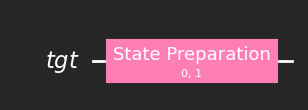

In [17]:
q_env.baseline_circuit.draw("mpl", style="iqp-dark", fold=20)

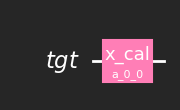

In [18]:
q_env.circuit.draw("mpl", style="iqp-dark", fold=20)

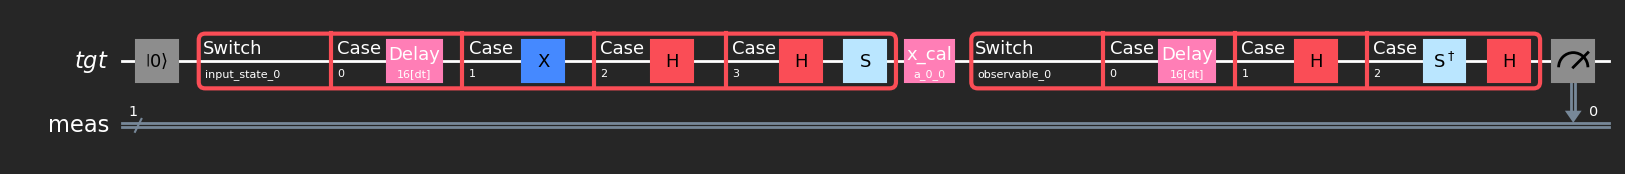

In [19]:
q_env.real_time_circuit.draw("mpl", style="iqp-dark", fold=25)

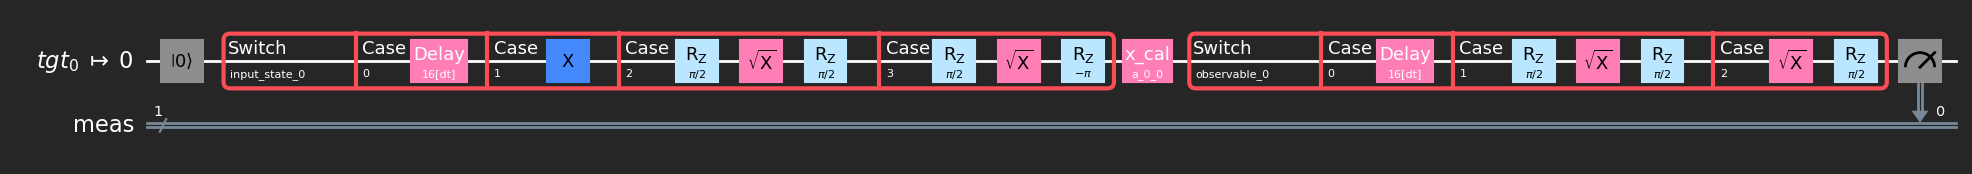

In [20]:
q_env.real_time_transpiled_circuit.draw("mpl", fold=32, style="iqp-dark")

In [21]:
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator, DensityMatrix
dm = DensityMatrix.from_label("1")
SparsePauliOp.from_operator(Operator(dm))

SparsePauliOp(['I', 'Z'],
              coeffs=[ 0.5+0.j, -0.5+0.j])

In [22]:
print(backend.oq3_exporter.dumps(q_env.real_time_transpiled_circuit))

OPENQASM 3.0;
input float[64] a_0_0;
input uint[4] observable_0;
input uint[8] input_state_0;
bit[1] meas;
int switch_dummy;
int switch_dummy_0;
reset $0;
switch_dummy = input_state_0;
switch (switch_dummy) {
  case 0 {
    delay[16dt] $0;
  }
  case 1 {
    x $0;
  }
  case 2 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
  }
  case 3 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(-3.141592653589793) $0;
  }
}
x_cal(a_0_0) $0;
switch_dummy_0 = observable_0;
switch (switch_dummy_0) {
  case 0 {
    delay[16dt] $0;
  }
  case 1 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
  }
  case 2 {
    sx $0;
    rz(1.5707963267948966) $0;
  }
}
meas[0] = measure $0;



In [23]:
from qm import generate_qua_script

print(generate_qua_script(q_env.rl_qoc_training_qua_prog(num_updates.total_updates)))


# Single QUA script generated at 2025-07-09 15:51:41.799738
# QUA library version: 1.2.2

from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_input_state_0 = declare_input_stream(int, 'input_state_0', value=0)
    input_stream_observable_0 = declare_input_stream(int, 'observable_0', value=0)
    input_stream_pauli_shots = declare_input_stream(int, 'pauli_shots', value=50)
    input_stream_max_observables = declare_input_stream(int, 'max_observables', value=0)
    v1 = declare(fixed, value=0.0)
    input_stream_mu = declare_input_stream(fixed, 'mu', value=[0.0])
    input_stream_sigma = declare_input_stream(fixed, 'sigma', value=[1.0])
    a1 = declare(int, value=[0, 0])
    v2 = declare(int, )
    v3 = declare(int, )
    v4 = declare(int, )
    v5 = declare(int, )
    v6 = declare(int, value=0)
    v7 = declare(int, )
    v8 = declare(int, )
    a2 = declare(fixed, size=1)
    a3 = declare(fixed, size=1)
    a4 = declare(fixed, value=[

In [24]:
reward.get_reward_data(
    q_env.circuit, np.zeros((q_env.batch_size, q_env.n_actions)), q_env.target, q_env.config
)

StateRewardDataList([StateRewardData(pub=EstimatorPub(<(2,)>), pauli_sampling=10, id_coeff=np.float64(1.0), input_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x16918d110>, observables=SparsePauliOp(['Z'],
              coeffs=[-10.+0.j]), n_reps=1, input_indices=(0,), observables_indices=[(0,)])])

In [25]:
ppo_config = PPOConfig.from_yaml("agent_config.yaml")
ppo_agent = CustomQMPPO(ppo_config, rescaled_env)

ppo_training = TrainingConfig(num_updates)
ppo_settings = TrainFunctionSettings(plot_real_time=True, print_debug=True, num_prints=10)

In [26]:
q_env.reward_data

In [27]:
print(backend.qmm.get_jobs(status="Running"))

2025-07-09 15:51:44,263 - qm - INFO     - Performing health check
2025-07-09 15:51:44 INFO Performing health check
2025-07-09 15:51:45,067 - qm - INFO     - Cluster healthcheck completed successfully.
2025-07-09 15:51:45 INFO Cluster healthcheck completed successfully.
[]


In [28]:
job = q_env.start_program()

/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/quam/quam/components/channels.py:647: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(


2025-07-09 15:51:49,739 - qm - INFO     - Clearing queue
2025-07-09 15:51:49 INFO Clearing queue
2025-07-09 15:51:51,075 - qm - INFO     - Adding program to queue.
2025-07-09 15:51:51 INFO Adding program to queue.


In [29]:
from qm.api.v2.job_api.job_api import JobApi
job

JobApiWithDeprecations(connection_details=ConnectionDetails(host='10.1.1.6', port=9510, user_token='', ssl_context=None, max_message_size=104857600, headers={'x-grpc-service': 'gateway', 'cluster_name': 'galil_arbel'}, timeout=60, debug_data=None), job_id=6f9fee4f-4370-4483-a94f-7bffadf2d082)

In [30]:
job.status

'running'

In [35]:
job.halt()

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_27829/2760244435.py:1: DeprecationWarning: job.halt is deprecated since "1.2.0" and will be removed in "1.4.0". This method was renamed to `job.cancel`.
  job.halt()


True

In [32]:
job.result_handles.a_0_0.fetch_all()

array([(-1.98000002,), (-1.98000002,), (-1.89877558,), (-1.89877558,),
       (-1.81755102,), (-1.81755102,), (-1.73632658,), (-1.73632658,),
       (-1.65510213,), (-1.65510213,), (-1.57387757,), (-1.57387757,),
       (-1.49265313,), (-1.49265313,), (-1.41142869,), (-1.41142869,),
       (-1.33020413,), (-1.33020413,), (-1.24897969,), (-1.24897969,),
       (-1.16775513,), (-1.16775513,), (-1.08653057,), (-1.08653057,),
       (-1.00530612,), (-1.00530612,), (-0.92408174,), (-0.92408174,),
       (-0.84285718,), (-0.84285718,), (-0.76163268,), (-0.76163268,),
       (-0.68040824,), (-0.68040824,), (-0.59918374,), (-0.59918374,),
       (-0.51795924,), (-0.51795924,), (-0.43673477,), (-0.43673477,),
       (-0.35551026,), (-0.35551026,), (-0.27428579,), (-0.27428579,),
       (-0.19306131,), (-0.19306131,), (-0.11183681,), (-0.11183681,),
       (-0.03061232,), (-0.03061232,), ( 0.05061217,), ( 0.05061217,),
       ( 0.13183665,), ( 0.13183665,), ( 0.21306115,), ( 0.21306115,),
      

In [31]:
q_env.std_action = np.array([0.01], dtype=np.float32)
reward = []
q_env.step_tracker = 0
q_env.clear_history()
for action in np.linspace(-1.0, 1.0, 30):
    q_env.mean_action = rescaled_env.action(np.array([action], dtype=np.float32))
    print(q_env.step(np.array([action], dtype=np.float32))[1])
    reward.append(q_env.reward_history[-1])
    q_env.step_tracker += 1

Pushing value [-1.9800000190734863] to mu through input stream.
Pushing value [0.009999999776482582] to sigma through input stream.
Just pushed policy parameters to OPX: [-1.9800000190734863] [0.009999999776482582]
Fetching index: 0, finishing index: 1
Fetching size: 1
Step indices: {0: (0, 1)}
Total data points: 1
Pushing value 0 to input_state_0 through input stream.
Pushing value 1 to max_observables through input stream.
Pushing value 500 to pauli_shots through input stream.
Pushing value 0 to observable_0 through input stream.
Fetching value from reward with input type None
Fetched value: [[[475  25]
  [488  12]]]
[-0. -0.]
Pushing value [-1.8427586555480957] to mu through input stream.
Pushing value [0.009999999776482582] to sigma through input stream.
Just pushed policy parameters to OPX: [-1.8427586555480957] [0.009999999776482582]
Fetching index: 1, finishing index: 2
Fetching size: 1
Step indices: {0: (0, 1), 1: (1, 2)}
Total data points: 2
Pushing value 0 to input_state_0 th

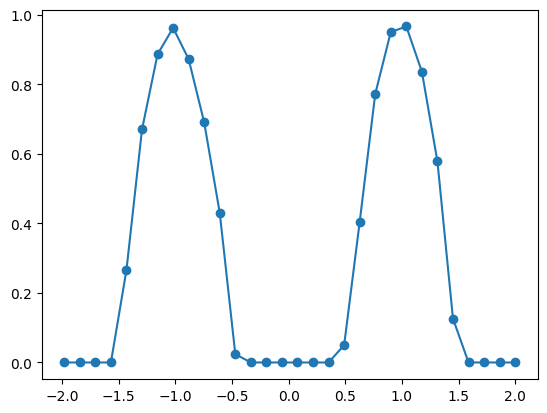

In [32]:
import matplotlib.pyplot as plt
plt.plot(rescaled_env.action(np.linspace(-1.0, 1.0, 30)), np.mean(q_env.reward_history, axis=-1), marker="o")

In [33]:
q_env.reward_history

[array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0.288, 0.244]),
 array([0.692, 0.648]),
 array([0.872, 0.9  ]),
 array([0.968, 0.956]),
 array([0.864, 0.88 ]),
 array([0.692, 0.688]),
 array([0.464, 0.396]),
 array([0.   , 0.048]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0.04, 0.06]),
 array([0.408, 0.4  ]),
 array([0.804, 0.74 ]),
 array([0.956, 0.944]),
 array([0.964, 0.968]),
 array([0.876, 0.796]),
 array([0.616, 0.54 ]),
 array([0.152, 0.1  ]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.])]

In [34]:
np.linspace(-1.0, 1.0, 30)

array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
       -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
       -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
        0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
        0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
        0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ])

In [34]:
q_env.close()

Job status:  canceled


True

In [ ]:
q_env.step_tracker += 1

In [ ]:
rescaled_env.step(np.array([0.497488], dtype=np.float32))

In [ ]:
job.status

'running'

In [ ]:
ppo_agent.train(ppo_training, ppo_settings)

In [56]:
q_env.config.reward.get_reward_data(
    q_env.circuit, np.zeros((2, q_env.n_actions)), q_env.target, q_env.config
)[0].hamiltonian

SparsePauliOp(['I', 'Z'],
              coeffs=[ 6.+0.j, -4.+0.j])

In [ ]:
q_env.reward_data.fiducials_indices

In [ ]:
q_env.policy.push_to_opx({"mu": [1.0], "sigma": [0.2]}, job, verbosity=2)

In [ ]:
q_env.max_input_state.push_to_opx(1, job, verbosity=2)

In [ ]:
q_env.input_state_vars.push_to_opx({"input_state_0": 1}, job, verbosity=2)

In [ ]:
q_env.qm_backend_config

In [ ]:
q_env.mean_action

In [ ]:
print(job.result_handles.reward.fetch_all()["value"])

In [69]:
results = job.result_handles.reward.fetch_all()["value"]

In [71]:
results

array([[[479,  21],
        [476,  24]],

       [[458,  42],
        [454,  46]],

       [[392, 108],
        [376, 124]],

       [[312, 188],
        [308, 192]],

       [[203, 297],
        [197, 303]],

       [[119, 381],
        [139, 361]],

       [[ 63, 437],
        [ 56, 444]],

       [[ 32, 468],
        [ 36, 464]],

       [[ 39, 461],
        [ 51, 449]],

       [[109, 391],
        [ 97, 403]],

       [[178, 322],
        [187, 313]],

       [[283, 217],
        [277, 223]],

       [[378, 122],
        [366, 134]],

       [[445,  55],
        [445,  55]],

       [[472,  28],
        [470,  30]],

       [[476,  24],
        [476,  24]],

       [[435,  65],
        [417,  83]],

       [[357, 143],
        [370, 130]],

       [[271, 229],
        [268, 232]],

       [[170, 330],
        [163, 337]],

       [[ 97, 403],
        [ 84, 416]],

       [[ 53, 447],
        [ 51, 449]],

       [[ 41, 459],
        [ 48, 452]],

       [[ 59, 441],
        [ 85, 

In [79]:
from qiskit.primitives import BitArray
counts = []
reward_array = np.zeros(shape=(q_env.config.batch_size,))
reward_data = q_env.reward_data
config = q_env.config
formatted_counts = []
collected_counts = results
count_idx = 0
num_qubits = q_env.config.target.causal_cone_size if isinstance(q_env.config.target, GateTarget) else q_env.config.target.n_qubits
dim = 2**num_qubits
binary = lambda n, l: bin(n)[2:].zfill(l)
num_obs = len(reward_data.observables_indices[0])
for o_idx in range(num_obs):
    formatted_counts.append([])
    counts_array = np.array(collected_counts[count_idx], dtype=int)
    formatted_counts[o_idx] = counts_array
    count_idx += 1
for batch_idx in range(config.batch_size):
    counts.append([])
    for o_idx in range(num_obs):
        counts[batch_idx].append(formatted_counts[o_idx][batch_idx])

for batch_idx in range(config.batch_size):
    exp_value = reward_data.id_coeff
    for o_idx in range(num_obs):
        counts_dict = {
            binary(i, num_qubits): int(counts[batch_idx][o_idx][i]) for i in range(dim)
        }
        obs = reward_data[0].observables.group_commuting(True)[o_idx]
        diag_obs = SparsePauliOp("I" * num_qubits, 0.0)
        for obs_, coeff in zip(obs.paulis, obs.coeffs):
            diag_obs_label = ""
            for char in obs_.to_label():
                diag_obs_label += char if char == "I" else "Z"
            diag_obs += SparsePauliOp(diag_obs_label, coeff)
        bit_array = BitArray.from_counts(counts_dict, num_bits=num_qubits)
        exp_value += bit_array.expectation_values(diag_obs.simplify())
    
    exp_value /= reward_data.pauli_sampling
    reward_array[batch_idx] = exp_value

In [83]:
counts

[[array([479,  21])], [array([476,  24])]]

In [45]:
reshaped_counts = []
for batch_idx in range(q_env.batch_size):
    reshaped_counts.append([])
    for i_idx in range(max_input_state):
        reshaped_counts[batch_idx].append([])
        for o_idx in range(num_obs_per_input_state[i_idx]):

            reshaped_counts[batch_idx][i_idx].append(
                formatted_counts[i_idx][o_idx][batch_idx]
            )

In [46]:
reshaped_counts

[[[array([1948,   52])]], [[array([1950,   50])]]]

In [ ]:
from qiskit.quantum_info import Statevector
Statevector.from_label("0").expectation_value(q_env.reward_data.hamiltonian/q_env.reward_data.pauli_sampling)

In [ ]:
q_env.reward_data.pauli_sampling

In [ ]:
q_env.reward_data[0].precision

In [ ]:
from torch.distributions import Normal
import torch
ppo_agent.process_action(Normal(ppo_agent.agent(torch.zeros((q_env.batch_size,2)))[0].detach(),ppo_agent.agent(torch.zeros((q_env.batch_size,2)))[1].detach() ))

In [49]:
q_env.reward_data.hamiltonian

SparsePauliOp(['I', 'Z'],
              coeffs=[ 4.+0.j, -6.+0.j])

In [ ]:
q_env.reward_data.id_coeff/20

In [47]:
from rl_qoc.qua.qua_utils import binary
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BitArray
reward = np.zeros(q_env.batch_size)
dim = 2**q_env.n_qubits
counts = reshaped_counts
for batch_idx in range(q_env.batch_size):
    exp_value = q_env.reward_data.id_coeff
    for i_idx in range(max_input_state):
        for o_idx in range(num_obs_per_input_state[i_idx]):
            counts_dict = {
                binary(i, q_env.n_qubits): counts[batch_idx][i_idx][o_idx][i]
                for i in range(dim)
            }
            print(counts_dict)
            obs = q_env.reward_data[i_idx].hamiltonian.group_commuting(True)[o_idx]
            print(obs)
            diag_obs = SparsePauliOp("I" * q_env.n_qubits, 0.0)
            for obs_, coeff in zip(obs.paulis, obs.coeffs):
                diag_obs_label = ""
                for char in obs_.to_label():
                    diag_obs_label += char if char == "I" else "Z"
                diag_obs += SparsePauliOp(diag_obs_label, coeff)
            bit_array = BitArray.from_counts(counts_dict, num_bits=q_env.n_qubits)
            print(diag_obs.simplify())
            exp_value += bit_array.expectation_values(diag_obs.simplify())
    exp_value /= q_env.reward_data.pauli_sampling
    reward[batch_idx] = exp_value

{'0': np.int64(1948), '1': np.int64(52)}
SparsePauliOp(['I', 'Z'],
              coeffs=[ 4.+0.j, -6.+0.j])
SparsePauliOp(['I', 'Z'],
              coeffs=[ 4.+0.j, -6.+0.j])
{'0': np.int64(1950), '1': np.int64(50)}
SparsePauliOp(['I', 'Z'],
              coeffs=[ 4.+0.j, -6.+0.j])
SparsePauliOp(['I', 'Z'],
              coeffs=[ 4.+0.j, -6.+0.j])


In [48]:
reward

array([0.2312, 0.23  ])

In [ ]:
job.result_handles.reward.fetch_all()["value"].shape

In [ ]:
counts = np.transpose(job.result_handles.reward.fetch_all()["value"], (1, 0, 2))

In [ ]:
from rl_qoc.qua.qua_utils import binary
from qiskit.primitives import BitArray

reward = np.zeros(q_env.batch_size)
for b in range(q_env.batch_size):
    sv = np.zeros(4)
    for i_idx in range(4):
        counts_dict = {binary(i, 1): counts[b, i_idx, i] for i in range(2)}
        bit_array = BitArray.from_counts(counts_dict, num_bits=1)
        sv[i_idx] = bit_array.get_int_counts().get(0, 0) / q_env.n_shots
    reward[b] = np.mean(sv)

reward

In [ ]:
-np.log10(1.0 - reward)

In [ ]:
print(job.result_handles.action.fetch_all())

In [ ]:
q_env._step_indices

In [ ]:
job.result_handles.reward.count_so_far()

In [ ]:
q_env._total_data_points

In [ ]:
job.status

In [ ]:
q_env.close()

In [ ]:
from qm.qua import *

with program() as qua_program:
    gate = declare_input_stream(fixed, name="gate_input_stream")

    a = declare(fixed)
    r1 = declare_stream()
    r2 = declare_stream()
    v2 = declare(
        bool,
    )
    advance_input_stream(gate)
    with while_(gate > 0):
        a = gate
        save(a, r1)
        assign(v2, (a > 0.2))
        save(v2, r2)
        advance_input_stream(gate)

    with stream_processing():
        r1.save_all("measurements")
        r2.save_all("state")

job = backend.qm.execute(qua_program)

In [ ]:
result = job.result_handles

optimization_sequence = [0.1, 0.4, 0.06]

for id, value in enumerate(optimization_sequence):
    job.push_to_input_stream("gate_input_stream", value)
    result.measurements.wait_for_values(id + 1)
    print("Full data", str(result.measurements.fetch_all()))
    print(f"{id}: Received ", str(result.measurements.fetch(id)))
    result.state.wait_for_values(id + 1)
    print(f"{id}: Received ", str(result.state.fetch(id)))
    print("Full data", str(result.state.fetch_all()))

# finish QUA program
job.push_to_input_stream("gate_input_stream", 0)

In [ ]:
# Single QUA script generated at 2025-06-09 11:30:49.218366
# QUA library version: 1.2.3a1

from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    a1 = declare(fixed, value=[0.0])
    v1 = declare(
        int,
    )
    a2 = declare(fixed, value=[1.0])
    v2 = declare(
        int,
    )
    v3 = declare(int, value=0)
    v4 = declare(
        int,
    )
    v5 = declare(
        int,
    )
    with for_(v5, 0, (v5 < 5), (v5 + 1)):
        pause()
        assign(a1[0], IO1)
        r1 = declare_stream()
        save(a1[0], r1)
    with stream_processing():
        r1.save_all("mu")


config = None

loaded_config = None


job = backend.qm.execute(prog)

In [ ]:
job.is_paused()

In [ ]:
backend.qm.set_io1_value(1.0)

In [ ]:
job.resume()

In [ ]:
job.is_paused()

In [ ]:
print(job.result_handles.mu.fetch_all())

In [ ]:
job.cancel()

In [ ]:
job.is_paused()

In [ ]:
print(job.result_handles.mu.fetch_all())

In [ ]:
job.cancel()